In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import make_grid
import os

In [97]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Configurations

In [2]:
horse_path = "./Dataset/data/Horse2Zebra/trainA/"
zebra_path = "./Dataset/data/Horse2Zebra/trainB/"
img_shape = 256
batch_size = 64

## Dataset and Dataloader

In [85]:
class MyDataset(Dataset):
    def __init__(self, img_dir_A, img_dir_B, transform=None):
        self.img_dir_a = img_dir_A
        self.img_dir_b = img_dir_B
        self.transform = transform
        self.file_list_a = os.listdir(img_dir_A)
        self.file_list_b = os.listdir(img_dir_B)
        self.length_a = len(self.file_list_a)
        self.length_b = len(self.file_list_b)
        self.dataset_length = max(len(self.file_list_a), len(self.file_list_b))

    def __len__(self):
        return self.dataset_length

    def __getitem__(self, idx):
        img_path_a = os.path.join(self.img_dir_a, self.file_list_a[idx % self.length_a])
        img_path_b = os.path.join(self.img_dir_b, self.file_list_b[idx % self.length_b])
        zebra_img = np.array(Image.open(self.img_dir_b).convert("RGB"))
        horse_img = np.array(Image.open(self.img_dir_a).convert("RGB")))
        if self.transform:
            augmentations = self.transform(image=zebra_img, image0=horse_img)
            zebra_img = augmentations["image"]
            horse_img = augmentations["image0"]
        return horse_img, zebra_img

SyntaxError: unmatched ')' (3353370425.py, line 19)

In [86]:
transform = T.Compose([
    T.Resize([img_shape, img_shape]),
    T.ToTensor()
])

In [87]:
train_dataset = MyDataset(horse_path, zebra_path, transform=transform)

In [88]:
print(len(train_dataset))

1334


In [89]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [92]:
def plot_imgs(dataloader, n_imgs=9, index=0):
    img_a, img_b = next(iter(dataloader))
    imgs = make_grid(img_a[:9], int(n_imgs**0.5), int(n_imgs**0.5))
    plt.imshow(imgs.permute(1,2,0).numpy())
    plt.axis("off")

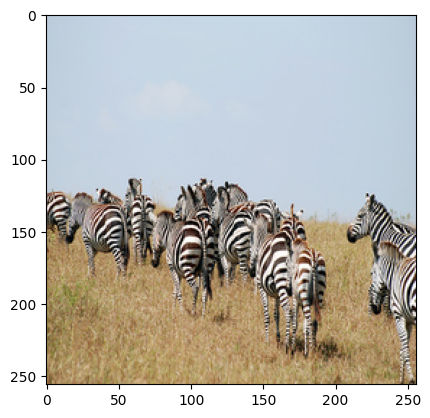

In [75]:
horse, zebra = next(iter(train_dataloader))
plt.imshow(zebra[0].permute(1,2,0).numpy())

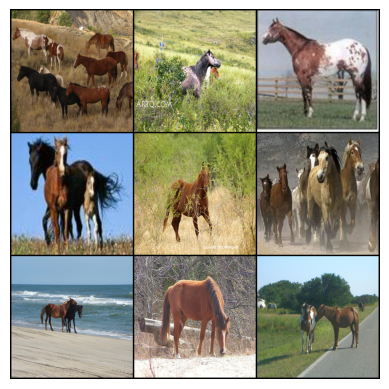

In [93]:
plot_imgs(train_dataloader)

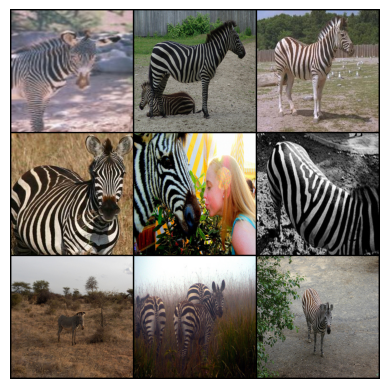

In [10]:
plot_imgs(zebra_dataloader)

## Discriminator

In [11]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size=4,
                stride=stride, padding=1,
                padding_mode="reflect", bias=True
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.conv(x)

In [12]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.layers = [
            Block(3, 64, 2),
            Block(64, 128, 2),
            Block(128, 256, 2),
            Block(256, 512, 1),
            Block(512, 1, 1)
        ]
        self.model = nn.Sequential(*self.layers)
    def forward(self, x):
        return self.model(x)

In [13]:
from torchsummary import summary

summary(Discriminator(), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
    InstanceNorm2d-2         [-1, 64, 128, 128]               0
         LeakyReLU-3         [-1, 64, 128, 128]               0
             Block-4         [-1, 64, 128, 128]               0
            Conv2d-5          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-6          [-1, 128, 64, 64]               0
         LeakyReLU-7          [-1, 128, 64, 64]               0
             Block-8          [-1, 128, 64, 64]               0
            Conv2d-9          [-1, 256, 32, 32]         524,544
   InstanceNorm2d-10          [-1, 256, 32, 32]               0
        LeakyReLU-11          [-1, 256, 32, 32]               0
            Block-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-14          [-1, 512,

## Generator

In [14]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, act=True):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size=kernel_size,
                stride=stride, padding=padding, padding_mode="reflect"
            ),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if act else nn.Identity()
        )
        
    def forward(self, x):
        return self.layer(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, act=True):
        super().__init__()
        self.layer = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels,kernel_size=kernel_size,
                stride=stride, padding=padding,
                output_padding=1
            ),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if act else nn.Identity()
        )
    def forward(self, x):
        return self.layer(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.layer = nn.Sequential(
            DownBlock(channels, channels, kernel_size=3, padding=1, stride=1),
            DownBlock(channels, channels, kernel_size=3, padding=1, stride=1, act=False),
        )
        
    def forward(self, x):
        return x + self.layer(x)
    

In [15]:
class Generator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.down_layers = nn.Sequential(
            DownBlock(in_channels, out_channels=64, kernel_size=7, stride=1, padding=3),
            DownBlock(64, out_channels=128, kernel_size=3, stride=2, padding=1),
            DownBlock(128, out_channels=256, kernel_size=3, stride=2, padding=1)
        )
        self.residual_layers = nn.Sequential(
            *[ResidualBlock(256) for _ in range(9)]
        )
        self.up_layers = nn.Sequential(
            UpBlock(256, out_channels=128, kernel_size=3, stride=2, padding=1),
            UpBlock(128, out_channels=64, kernel_size=3, stride=2, padding=1),
        )
        self.out = nn.Sequential(
            nn.Conv2d(64, out_channels=3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.down_layers(x)
        x = self.residual_layers(x)
        x = self.up_layers(x)
        return self.out(x)

In [16]:
summary(Generator(), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-2         [-1, 64, 256, 256]               0
              ReLU-3         [-1, 64, 256, 256]               0
         DownBlock-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-6        [-1, 128, 128, 128]               0
              ReLU-7        [-1, 128, 128, 128]               0
         DownBlock-8        [-1, 128, 128, 128]               0
            Conv2d-9          [-1, 256, 64, 64]         295,168
   InstanceNorm2d-10          [-1, 256, 64, 64]               0
             ReLU-11          [-1, 256, 64, 64]               0
        DownBlock-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-14          [-1, 256,

In [94]:
import itertools

## Training

In [101]:
def train(generator_g, generator_f, discriminator_x, discriminator_y, epochs, batch_size, lr, train_dataloader):
    history = {'G_loss':[], 'D_X':[], 'D_Y':[]}
    loss_fn = nn.MSELoss()
    l1 = nn.L1Loss()
    g_optimizer = optim.Adam(itertools.chain(generator_g.parameters(), generator_f.parameters()), lr=lr)
    x_optimizer = optim.Adam(discriminator_x.parameters(), lr=lr)
    y_optimizer = optim.Adam(discriminator_y.parameters(), lr=lr)
    
    for epoch in range(epochs):
        for i, (horse, zebra) in enumerate(train_dataloader):
            horse = horse.to(device)
            zebra = zebra.to(device)
            
            zebra_g = generator_g(horse)
            x_optimizer.zero_grad()
            
            x_real = discriminator_x(zebra)
            x_fake = discriminator_x(zebra_g)
            x_real_loss = x_real.mean().item()
            x_fake_loss= x_fake.mean().item()
            
            dx_real_loss = loss_fn(x_real, torch.ones_like(x_real))
            dx_fake_loss = loss_fn(x_fake, torch.zeros_like(x_fake))
            d_x_loss = (dx_real_loss + dx_fake_loss)/2
            
            d_x_loss.backward()
            x_optimizer.step()

            y_optimizer.zero_grad()
            horse_g = generator_f(zebra_g)
            y_real = discriminator_y(horse)
            y_fake = discriminator_y(horse_g)

            y_real_loss = y_real.mean().item()
            y_fake_loss = y_fake.mean().item()

            dy_real_loss = loss_fn(y_real, torch.ones_like(y_real))
            dy_fake_loss = loss_fn(y_fake, torch.zeros_like(y_fake))

            d_y_loss = (dy_real_loss + dy_fake_loss)/2
            
            d_y_loss.backward()
            y_optimizer.step()
                
            if i % 5 == 0:
                g_optimizer.zero_grad()
                zebra_g = generator_g(horse)
                fake_x = discriminator_x(zebra_g).mean().item()
                g_loss = loss_fn(fake_x, torch.ones_like(fake_x))
                
                horse_g = generator_f(zebra)
                fake_y = discriminator_y(horse_g).mean().item()
                f_loss = loss_fn(fake_y, torch.ones_like(fake_x))

                cycle_loss = l1(generator_f(generator_g(horse)), horse) + l1(generator_g(generator_f(zebra)), zebra)
                total_loss = g_loss + f_loss + cycle_loss

                total_loss.backward()
                g_optimizer.step()

            if i%100 == 0:
                with torch.inference_mode():
                    history['G_loss'].append(total_loss.item())
                    history['D_X'].append(d_x_loss.item())
                    history['D_Y'].append(d_y_loss.item())
                    print(f"Epoch {epoch} : Discriminator_X : {history['D_X']} Discriminator_Y : {history['D_Y']} Generator : {history['G_loss']}")
            

In [102]:
generator_g = Generator()
generator_f = Generator()
discriminator_x = Discriminator()
discriminator_y = Discriminator()

generator_g.to(device)
generator_f.to(device)
discriminator_x.to(device)
discriminator_y.to(device)

Discriminator(
  (model): Sequential(
    (0): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): Block(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): Block(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (3): Block(
      (conv): Sequential(
        (0): Conv2d(25

In [103]:
train(generator_g, generator_f, discriminator_x, discriminator_y, epochs=5, batch_size=batch_size, lr=2e-4, train_dataloader=train_dataloader)


KeyboardInterrupt

